# OMNI - RNN Regression model 

## Importing libraries & Data

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from graphviz import Digraph

In [2]:
# Directory containing the data files
data_dir = 'omni_data'

## Data Preproseessing

In [3]:
# Initialize an empty DataFrame to store the data
solar_data = pd.DataFrame()

In [4]:
# Loop through the years from 2004 to 2023
for year in range(2004, 2024):
    # Construct the filename for the data file
    file_name = f'omni_min_{year}.lst'
    file_path = os.path.join(data_dir, file_name)

    # columns name for easy access
    common_header = ["YYYY", "DOY", "HR", "MN"]
    headers = ["Timeshift", "Field magnitude average(nT)", "Speed(km/s)", "Proton Density(n/cc)", "Temperature(K)",
               "FlowPressure(nPa)"]

    # graph_label for headers(short)
    graph_header = ["TimeShift", "Magnetic Field", "Speed", "Density", "Tempt", "Pressure"]

    common_header.extend(headers)

    # Check if the file exists before attempting to read it
    if os.path.isfile(file_path):
        # Read the data from the file into a DataFrame
        data = pd.read_csv(file_path, sep='\s+', names=common_header)

        # Append the data to the combined DataFrame
        solar_data = solar_data.append(data)

# Reset the index of the combined DataFrame
solar_data.reset_index(drop=True, inplace=True)

C:\Users\muham\AppData\Local\Temp\ipykernel_9816\1094158808.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solar_data = solar_data.append(data)
C:\Users\muham\AppData\Local\Temp\ipykernel_9816\1094158808.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solar_data = solar_data.append(data)
C:\Users\muham\AppData\Local\Temp\ipykernel_9816\1094158808.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solar_data = solar_data.append(data)
C:\Users\muham\AppData\Local\Temp\ipykernel_9816\1094158808.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solar_data = solar_data.append(data)
C:\Users\muham\AppData\Local\Temp\ipykernel_

In [5]:
# To remove the outliers
# This takes the highest value(999,9999,999999) outliers from the series so before using this we should be sure our all column
# have outliers and then later remove the column not having outliers from list headers
for itm in headers:
    solar_data.replace(to_replace=solar_data[itm].max(), value=np.NaN, inplace=True)
    solar_data.fillna(method='bfill', inplace=True)

In [6]:
solar_data.describe()

,YYYY,DOY,HR,MN,Timeshift,Field magnitude average(nT),Speed(km/s),Proton Density(n/cc),Temperature(K),FlowPressure(nPa)
count,57600.000000,57600.000000,57600.000000,57600.000000,57600.000000,57600.000000,57600.000000,57600.000000,5.760000e+04,57600.000000
mean,2013.500000,238.750000,11.500000,29.500000,3429.379497,6.090834,413.095273,6.981718,8.918654e+04,2.070726
std,5.766331,0.661444,6.922247,17.318253,1045.662655,3.248565,99.650143,6.422742,9.286807e+04,1.636582
min,2004.000000,238.000000,0.000000,0.000000,-2077.000000,0.220000,253.600000,0.760000,5.653000e+03,0.290000
25%,2008.750000,238.000000,5.750000,14.750000,2761.000000,4.050000,343.000000,3.180000,2.788750e+04,1.140000
50%,2013.500000,239.000000,11.500000,29.500000,3402.000000,5.180000,386.600000,4.860000,6.042750e+04,1.630000
75%,2018.250000,239.000000,17.250000,44.250000,4016.000000,6.900000,442.000000,8.580000,1.175632e+05,2.370000
max,2023.000000,240.000000,23.000000,59.000000,10028.000000,21.380000,742.200000,64.690000,1.028652e+06,17.660000


## Feature Extraction

In [7]:
# Define selected features and target variables
selected_features = ["FlowPressure(nPa)", "Temperature(K)"]
target_variables = ["Speed(km/s)", "Field magnitude average(nT)"]

In [8]:
# Split the data into features (X) and target (y)
X = solar_data[selected_features].values
y = solar_data[target_variables].values

# Normalize the data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

## Model building 

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Build the RNN model with an additional LSTM layer and a dropout layer
model = keras.Sequential([
    keras.layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),
    keras.layers.LSTM(50, activation='relu'),  # Second LSTM layer
    keras.layers.Dropout(0.2),  # Dropout layer to prevent overfitting
    keras.layers.Dense(2)  # Two output neurons for speed and field magnitude
])

In [11]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
# Function to visualize the model using Graphviz
def visualize_model(model):
    dot = Digraph(comment='RNN Model', format='png')

    # Input layer
    dot.node('input', label=f'Input\n({X_train.shape[1]}, 1)')

    # First LSTM layer
    dot.node('lstm1', label='LSTM (50, relu)\n(return sequences=True)')

    # Second LSTM layer
    dot.node('lstm2', label='LSTM (50, relu)')

    # Dropout layer
    dot.node('dropout', label='Dropout (0.2)')

    # Dense layer
    dot.node('dense', label='Dense (2)')

    # Connect layers
    dot.edge('input', 'lstm1')
    dot.edge('lstm1', 'lstm2')
    dot.edge('lstm2', 'dropout')
    dot.edge('dropout', 'dense')

    # Save the diagram as an image
    dot.render('omni_rnn_model_diagram', view=False)

In [13]:
# Visualize the model
visualize_model(model)

In [14]:
# Train the model
history = model.fit(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), y_train,
                    epochs=100, batch_size=32, validation_data=(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)), y_test))

Epoch 1/100
1440/1440 [==============================] - 14s 8ms/step - loss: 0.0249 - val_loss: 0.0173
Epoch 2/100
1440/1440 [==============================] - 10s 7ms/step - loss: 0.0174 - val_loss: 0.0162
Epoch 3/100
1440/1440 [==============================] - 10s 7ms/step - loss: 0.0165 - val_loss: 0.0159
Epoch 4/100
1440/1440 [==============================] - 10s 7ms/step - loss: 0.0163 - val_loss: 0.0157
Epoch 5/100
1440/1440 [==============================] - 9s 6ms/step - loss: 0.0162 - val_loss: 0.0163
Epoch 6/100
1440/1440 [==============================] - 14s 10ms/step - loss: 0.0161 - val_loss: 0.0156
Epoch 7/100
1440/1440 [==============================] - 11s 8ms/step - loss: 0.0160 - val_loss: 0.0155
Epoch 8/100
1440/1440 [==============================] - 10s 7ms/step - loss: 0.0160 - val_loss: 0.0158
Epoch 9/100
1440/1440 [==============================] - 11s 7ms/step - loss: 0.0159 - val_loss: 0.0156
Epoch 10/100
1440/1440 [==============================] - 11s 8m

1440/1440 [==============================] - 12s 8ms/step - loss: 0.0152 - val_loss: 0.0152
Epoch 80/100
1440/1440 [==============================] - 14s 10ms/step - loss: 0.0152 - val_loss: 0.0151
Epoch 81/100
1440/1440 [==============================] - 15s 10ms/step - loss: 0.0153 - val_loss: 0.0150
Epoch 82/100
1440/1440 [==============================] - 11s 8ms/step - loss: 0.0152 - val_loss: 0.0150
Epoch 83/100
1440/1440 [==============================] - 12s 8ms/step - loss: 0.0152 - val_loss: 0.0150
Epoch 84/100
1440/1440 [==============================] - 19s 13ms/step - loss: 0.0152 - val_loss: 0.0150
Epoch 85/100
1440/1440 [==============================] - 12s 8ms/step - loss: 0.0152 - val_loss: 0.0150
Epoch 86/100
1440/1440 [==============================] - 10s 7ms/step - loss: 0.0152 - val_loss: 0.0150
Epoch 87/100
1440/1440 [==============================] - 10s 7ms/step - loss: 0.0152 - val_loss: 0.0149
Epoch 88/100
1440/1440 [==============================] - 12s 8ms

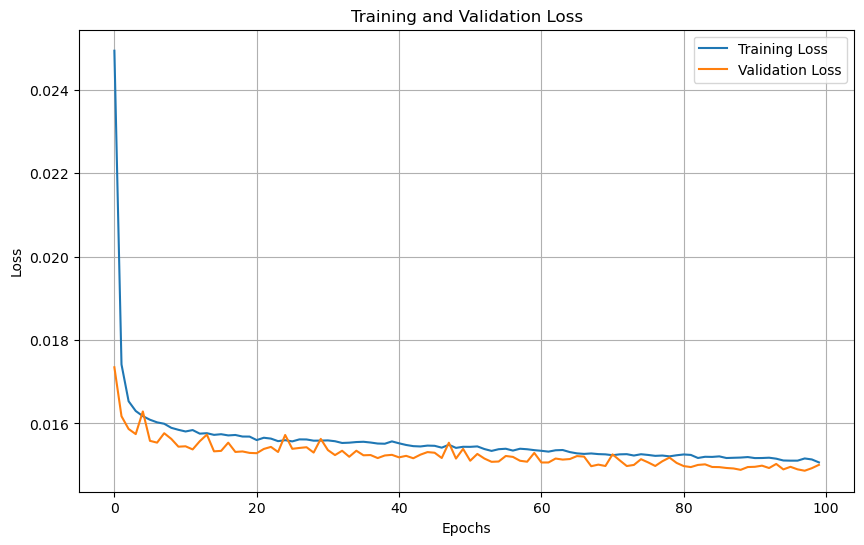

In [15]:
# Plot training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## Prediction 

In [16]:
# Make predictions on the test data
y_pred = model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)))

360/360 [==============================] - 2s 3ms/step


In [17]:
# Inverse transform the scaled predictions to the original scale
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

In [18]:
# Calculating and printing the Mean Squared Error (MSE) for each target variable
mse_speed = np.mean((y_pred[:, 0] - y_test[:, 0]) ** 2)
mse_field_magnitude = np.mean((y_pred[:, 1] - y_test[:, 1]) ** 2)

In [19]:
print(f'MSE for Speed: {mse_speed}')
print(f'MSE for Field Magnitude: {mse_field_magnitude}')

MSE for Speed: 3612.6978236955424
MSE for Field Magnitude: 6.662323168154226


## Saving the model to a file

In [20]:
# Save the model to a file in HDF5 format
model.save('omni_rnn_model.h5')  

C:\Users\muham\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
